In [1]:
import dwdatareader as dw
import matplotlib.pyplot as plt 
import noisereduce as nr
from IPython.display import Audio
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.signal import butter,filtfilt
import numpy as np
import acoustics.signal as S
import pandas as pd
import re
import os
import librosa as l
import scipy
import PyOctaveBand
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import mixture
from sklearn.svm import SVC
import more_itertools as mit
import seaborn as sns
import math
import os
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import percentile
from model import machine
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
from sklearn.metrics import f1_score
from mlxtend.evaluate import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
import random


c:\Users\anand\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_model(train_data, train_label,model_name):
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
        model.fit(train_data, train_label)
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
        model.fit(train_data, train_label)
    elif model_name=='Autoencoder':
        print("Autoencoder")
    return model
    
def evaluation_matrix(model, train_data, train_label, test_data, test_label):
    cM=metrics.confusion_matrix(test_label, model.predict(test_data))
    print("Confusion matrix \n",cM)

    bal_accuracy= balanced_accuracy_score(test_label, model.predict(test_data))
    print("Balance Accuracy=",bal_accuracy)
    print("Class wise accuracy",cM.diagonal()/cM.sum(axis=1))
    print("Per class accuracy class 1", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=1))
    print("Per class accuracy class 0", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=0))
    print("average per class  accuracy", accuracy_score(test_label, model.predict(test_data),method='average'))

    cR=metrics.classification_report(test_label, model.predict(test_data))
    print("ClassificationReport \n",cR)   

    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    scores = cross_val_score(model,train_data, train_label, cv=cv,scoring="accuracy")
    print('Scores',scores, np.average(scores))

    f1_weighted_1=f1_score(test_label, model.predict(test_data),average='weighted')
    print("F1 weighted",f1_weighted_1)#,f1_weighted_0)
    print("Precison weighted", precision_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))
    print("recall weighted", recall_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))

    print("Confusion matrix \n")
    ConfusionMatrixDisplay.from_predictions(test_label, model.predict(test_data))
    plt.show()
   
    rf_disp = RocCurveDisplay.from_estimator(model, test_data, test_label)
    plt.show()

    fig, ax = plt.subplots(1,2,figsize=(15,6))
    pr = skplt.metrics.plot_precision_recall(test_label, model.predict_proba(test_data),ax=ax[1])
    roc = skplt.metrics.plot_roc(test_label, model.predict_proba(test_data),ax=ax[0])
    plt.show()
    
def undersampling(train_data, train_label):
    rus = RandomUnderSampler()
    undersample_data,undersample_label=rus.fit_resample(train_data, train_label)
    print("Length of train: ", len(undersample_data),"Length of label :", len(undersample_label))
    unique, counts = np.unique(undersample_label, return_counts=True)
    d3=dict(zip(unique, counts))
    print(f"Numbers of class instances (Undersampling): {d3}")
    return undersample_data, undersample_label

def normalize_data(data):
    norm_time=MinMaxScaler()
    norm_time.fit(data.iloc[:,:-1])
    norm_data=norm_time.transform(data.iloc[:,:-1])
    norm_data=pd.concat([pd.DataFrame(norm_data),data.iloc[:,-1:]],axis=1)

    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])
    
    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")
    return norm_data
    
def split_data(data,label):
    indices = np.arange(len(data))
    x_train, x_test, y_train, y_test,indices_train,indices_test= train_test_split(data, label, indices, test_size=0.2,random_state=20,shuffle=True)
    return x_train, x_test, y_train, y_test,indices_train,indices_test
def learning_curve_plot(model,data,label,model_name):
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
    train_size=[]    
    datasize=int(data.shape[0]*0.8)
    for i in range(0,5):
        train_size.append(random.randint(1,datasize))
    train_size.sort()

    train_sizes,train_scores,validation_scores=learning_curve(estimator=model, X=data, y=label, train_sizes=train_size, cv = 5, scoring = 'balanced_accuracy')

    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    # print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
    # print('\n', '-' * 20) # separator
    # print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training Accuracy')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Accuracy')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for '+model_name, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()

# II TIME

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv -------------
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Length of train:  15016 Length of test : 3755
Numbers of class instances (Train): {0: 845, 1: 14171}
Numbers of class instances (Test): {0: 227, 1: 3528}
Length of train:  1690 Length of label : 1690
Numbers of class instances (Undersampling): {0: 845, 1: 845}
---------------Train Random forest----------------
Confusion matrix 
 [[ 182   45]
 [ 926 2602]]
Balance Accuracy= 0.7696452296043234
Class wise accuracy [0.80176211 0.73752834]
Per class accuracy class 1 0.7414114513981358
Per class accuracy class 0 0.7414114513981358
average per class  accuracy 0.7414114513981358
ClassificationReport 
               precision    recall  f1-score   support

           0       0.16      0.80      0.27       227
           1       0.98      0.74      0.84      3528

   

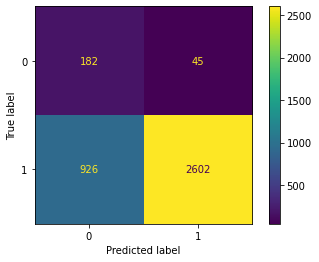

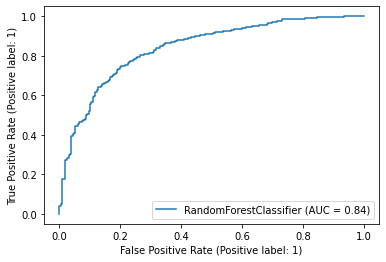

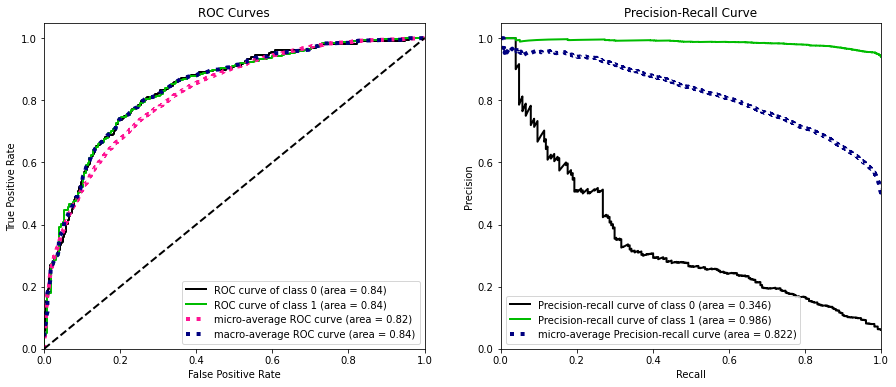

-------------------Train SVM----------------------
Confusion matrix 
 [[ 180   47]
 [1620 1908]]
Balance Accuracy= 0.6668839341904162
Class wise accuracy [0.79295154 0.54081633]
Per class accuracy class 1 0.5560585885486019
Per class accuracy class 0 0.5560585885486019
average per class  accuracy 0.5560585885486019
ClassificationReport 
               precision    recall  f1-score   support

           0       0.10      0.79      0.18       227
           1       0.98      0.54      0.70      3528

    accuracy                           0.56      3755
   macro avg       0.54      0.67      0.44      3755
weighted avg       0.92      0.56      0.66      3755

Scores [0.64201183 0.64201183 0.64497041 0.67159763 0.67455621] 0.6550295857988165
F1 weighted 0.6646326602015811
Precison weighted 0.9230049618411597
recall weighted 0.5560585885486019
Confusion matrix 



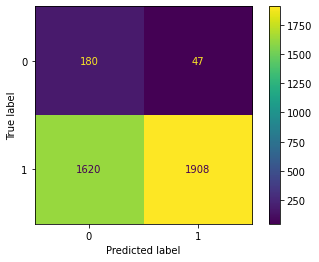

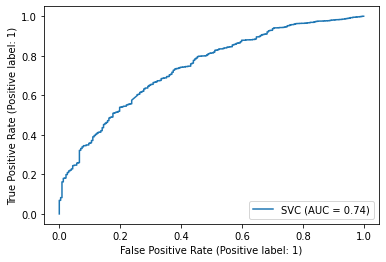

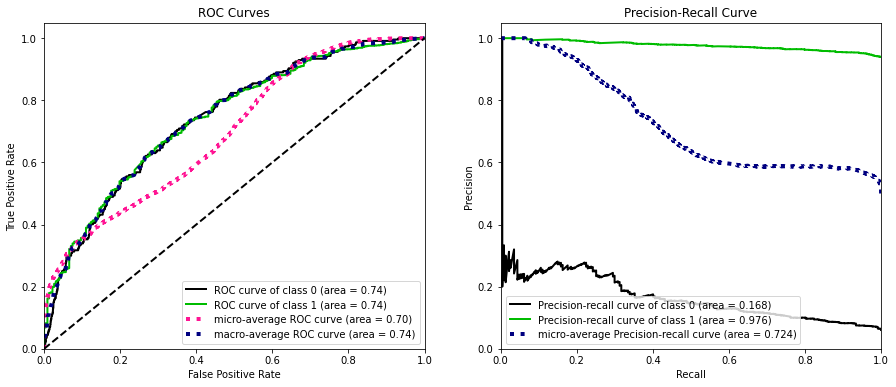

In [3]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.columns=time_col_list

new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

## Normalize data
norm_data= normalize_data(new_df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)

print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)


# III TIME

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/III.csv -------------
Numbers of class instances (Raw): {0: 5725, 1: 956}
Numbers of class instances (Raw): {0: 5725, 1: 956}
Length of train:  5344 Length of test : 1337
Numbers of class instances (Train): {0: 4587, 1: 757}
Numbers of class instances (Test): {0: 1138, 1: 199}
Length of train:  1514 Length of label : 1514
Numbers of class instances (Undersampling): {0: 757, 1: 757}
---------------Train Random forest----------------
Confusion matrix 
 [[870 268]
 [ 65 134]]
Balance Accuracy= 0.7189329777181162
Class wise accuracy [0.76449912 0.67336683]
Per class accuracy class 1 0.7509349289454001
Per class accuracy class 0 0.7509349289454001
average per class  accuracy 0.7509349289454001
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.76      0.84      1138
           1       0.33      0.67      0.45       199

    accuracy

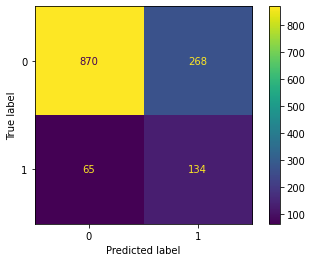

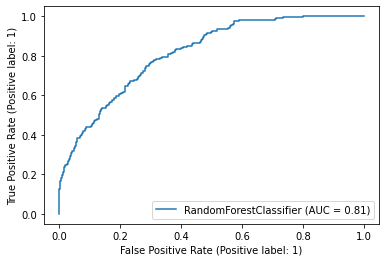

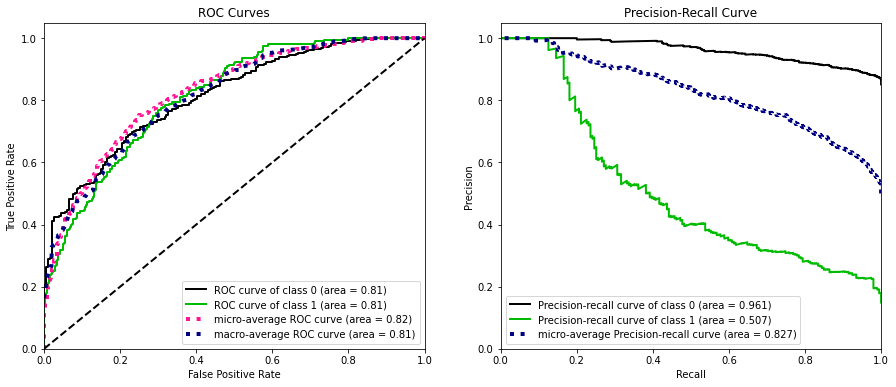

-------------------Train SVM----------------------
Confusion matrix 
 [[694 444]
 [101  98]]
Balance Accuracy= 0.5511520696629015
Class wise accuracy [0.60984183 0.49246231]
Per class accuracy class 1 0.5923709798055348
Per class accuracy class 0 0.5923709798055348
average per class  accuracy 0.5923709798055348
ClassificationReport 
               precision    recall  f1-score   support

           0       0.87      0.61      0.72      1138
           1       0.18      0.49      0.26       199

    accuracy                           0.59      1337
   macro avg       0.53      0.55      0.49      1337
weighted avg       0.77      0.59      0.65      1337

Scores [0.55115512 0.58415842 0.53135314 0.54125413 0.60264901] 0.5621139597403448
F1 weighted 0.6505485277565735
Precison weighted 0.7699367607977317
recall weighted 0.5923709798055348
Confusion matrix 



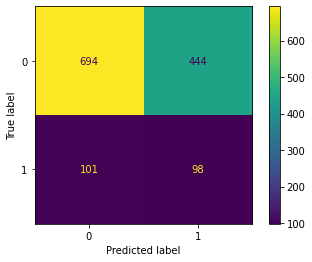

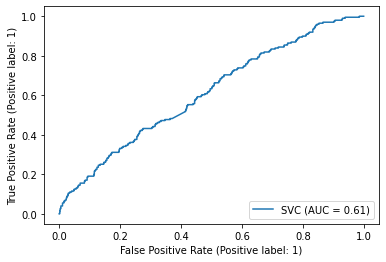

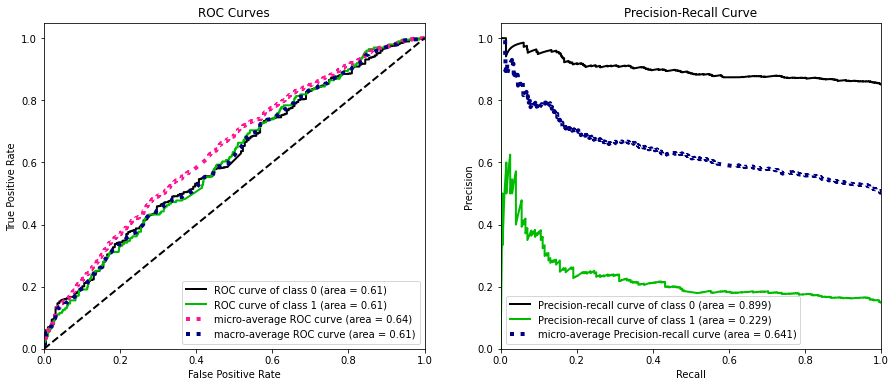

In [4]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/III.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.columns=time_col_list

new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

## Normalize data
norm_data= normalize_data(new_df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV TIME

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv -------------
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Length of train:  15100 Length of test : 3775
Numbers of class instances (Train): {0: 13789, 1: 1311}
Numbers of class instances (Test): {0: 3450, 1: 325}
Length of train:  2622 Length of label : 2622
Numbers of class instances (Undersampling): {0: 1311, 1: 1311}
---------------Train Random forest----------------
Confusion matrix 
 [[2741  709]
 [  97  228]]
Balance Accuracy= 0.748015607580825
Class wise accuracy [0.79449275 0.70153846]
Per class accuracy class 1 0.7864900662251656
Per class accuracy class 0 0.7864900662251656
average per class  accuracy 0.7864900662251656
ClassificationReport 
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      3450
           1       0.24      0.70      0.36       325

 

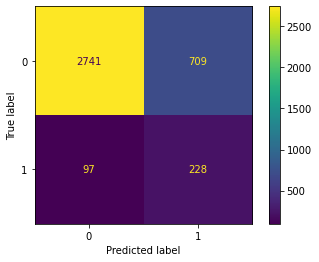

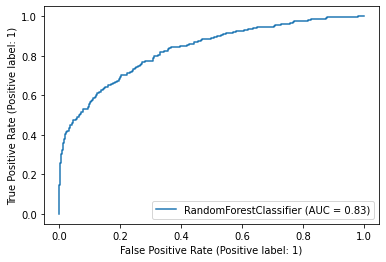

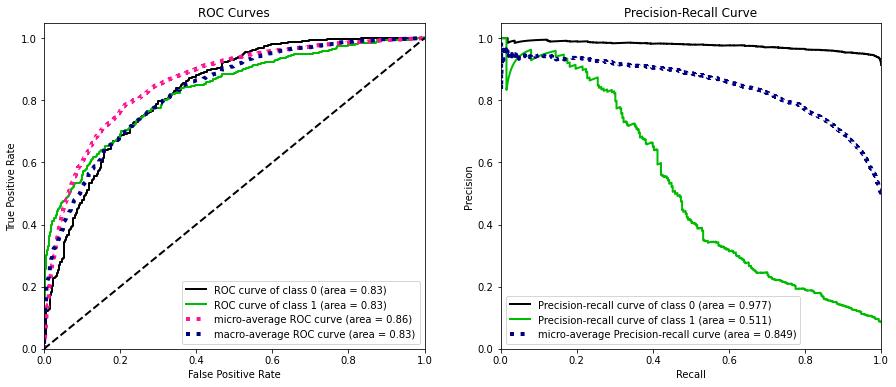

-------------------Train SVM----------------------
Confusion matrix 
 [[3299  151]
 [ 205  120]]
Balance Accuracy= 0.6627313266443702
Class wise accuracy [0.95623188 0.36923077]
Per class accuracy class 1 0.9056953642384106
Per class accuracy class 0 0.9056953642384106
average per class  accuracy 0.9056953642384106
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      3450
           1       0.44      0.37      0.40       325

    accuracy                           0.91      3775
   macro avg       0.69      0.66      0.68      3775
weighted avg       0.90      0.91      0.90      3775

Scores [0.64952381 0.63809524 0.68320611 0.66984733 0.66603053] 0.6613406034169392
F1 weighted 0.9017893269611714
Precison weighted 0.8985617710436381
recall weighted 0.9056953642384106
Confusion matrix 



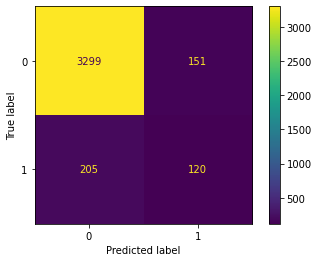

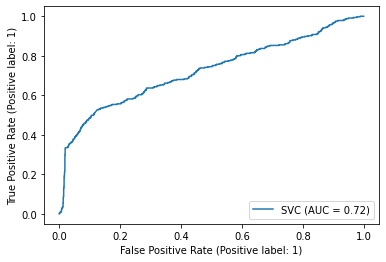

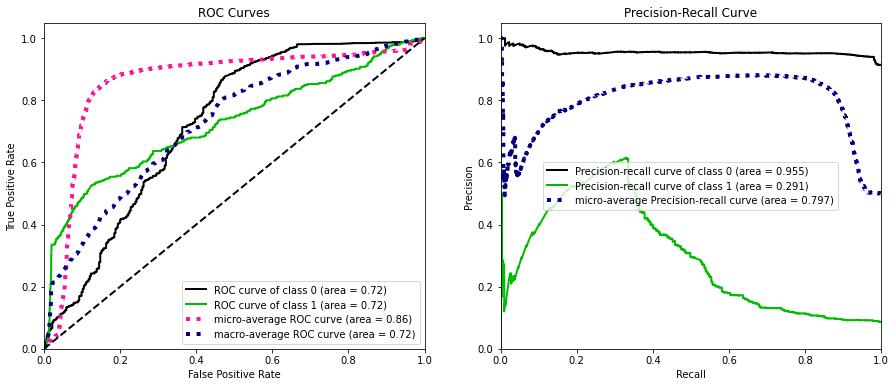

In [5]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.columns=time_col_list

new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

## Normalize data
norm_data= normalize_data(new_df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# II MFCC

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/II.csv -------------
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Length of train:  15016 Length of test : 3755
Numbers of class instances (Train): {0: 845, 1: 14171}
Numbers of class instances (Test): {0: 227, 1: 3528}
Length of train:  1690 Length of label : 1690
Numbers of class instances (Undersampling): {0: 845, 1: 845}
---------------Train Random forest----------------
Confusion matrix 
 [[ 188   39]
 [ 841 2687]]
Balance Accuracy= 0.7949075738959314
Class wise accuracy [0.82819383 0.76162132]
Per class accuracy class 1 0.7656458055925432
Per class accuracy class 0 0.7656458055925432
average per class  accuracy 0.7656458055925432
ClassificationReport 
               precision    recall  f1-score   support

           0       0.18      0.83      0.30       227
           1       0.99      0.76      0.86      3528

   

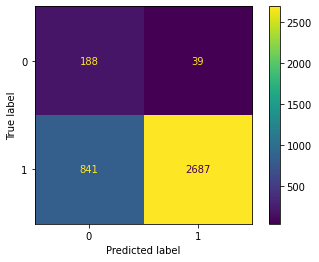

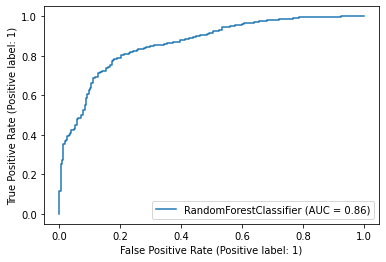

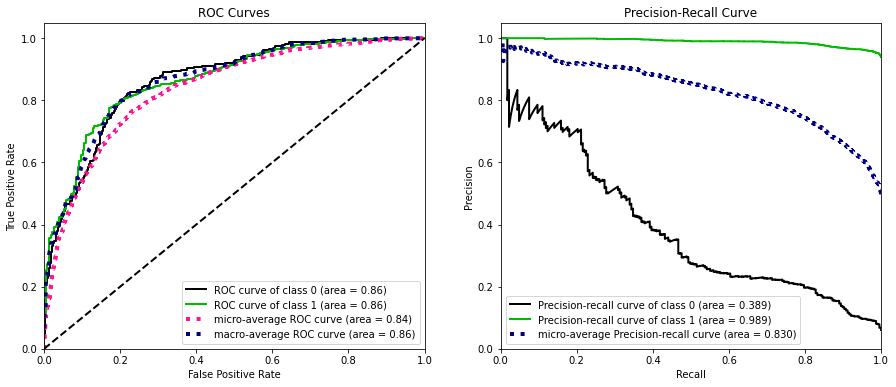

-------------------Train SVM----------------------
Confusion matrix 
 [[ 188   39]
 [ 813 2715]]
Balance Accuracy= 0.7988758278641853
Class wise accuracy [0.82819383 0.76955782]
Per class accuracy class 1 0.7731025299600532
Per class accuracy class 0 0.7731025299600532
average per class  accuracy 0.7731025299600532
ClassificationReport 
               precision    recall  f1-score   support

           0       0.19      0.83      0.31       227
           1       0.99      0.77      0.86      3528

    accuracy                           0.77      3755
   macro avg       0.59      0.80      0.59      3755
weighted avg       0.94      0.77      0.83      3755

Scores [0.76627219 0.71893491 0.77514793 0.76331361 0.83727811] 0.7721893491124261
F1 weighted 0.8306305672373618
Precison weighted 0.9375958940931135
recall weighted 0.7731025299600532
Confusion matrix 



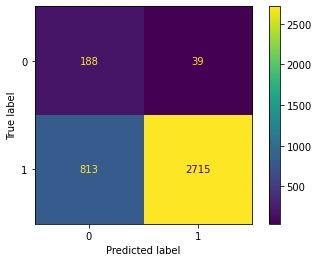

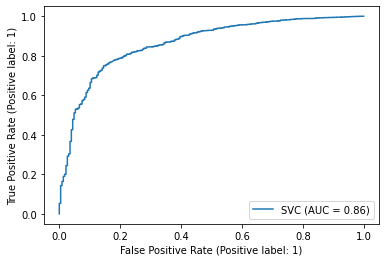

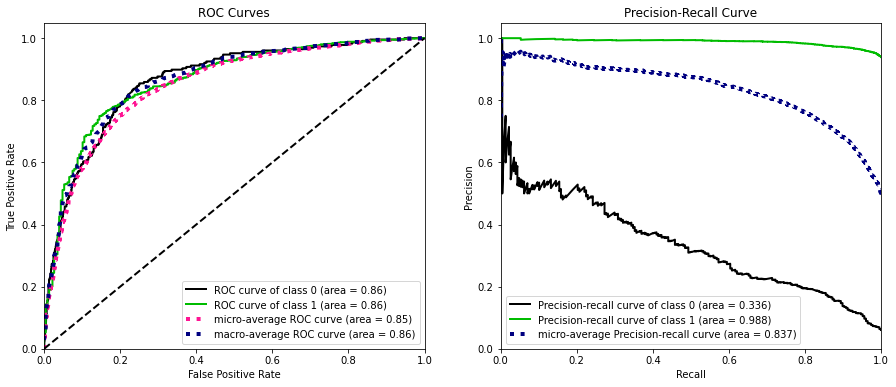

In [22]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/II.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# III MFCC

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/III.csv -------------
Numbers of class instances (Raw): {0: 5725, 1: 956}
Numbers of class instances (Raw): {0: 5725, 1: 956}
Length of train:  5344 Length of test : 1337
Numbers of class instances (Train): {0: 4587, 1: 757}
Numbers of class instances (Test): {0: 1138, 1: 199}
Length of train:  1514 Length of label : 1514
Numbers of class instances (Undersampling): {0: 757, 1: 757}
---------------Train Random forest----------------
Confusion matrix 
 [[870 268]
 [ 67 132]]
Balance Accuracy= 0.7139078520899753
Class wise accuracy [0.76449912 0.66331658]
Per class accuracy class 1 0.74943904263276
Per class accuracy class 0 0.74943904263276
average per class  accuracy 0.74943904263276
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.76      0.84      1138
           1       0.33      0.66      0.44       199

    accuracy      

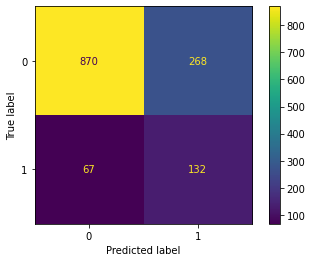

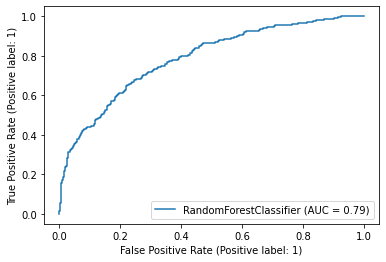

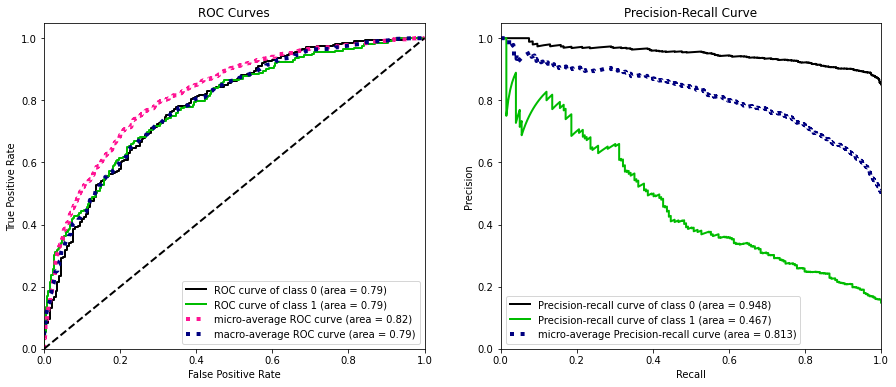

-------------------Train SVM----------------------
Confusion matrix 
 [[881 257]
 [ 54 145]]
Balance Accuracy= 0.7514042090946826
Class wise accuracy [0.7741652  0.72864322]
Per class accuracy class 1 0.7673896783844428
Per class accuracy class 0 0.7673896783844428
average per class  accuracy 0.7673896783844428
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.77      0.85      1138
           1       0.36      0.73      0.48       199

    accuracy                           0.77      1337
   macro avg       0.65      0.75      0.67      1337
weighted avg       0.86      0.77      0.80      1337

Scores [0.75907591 0.70627063 0.7359736  0.75907591 0.71523179] 0.7351255655366862
F1 weighted 0.7952848514333306
Precison weighted 0.8556877657397539
recall weighted 0.7673896783844428
Confusion matrix 



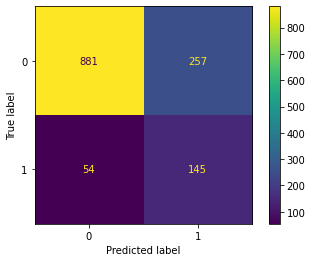

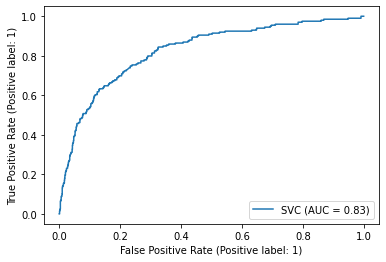

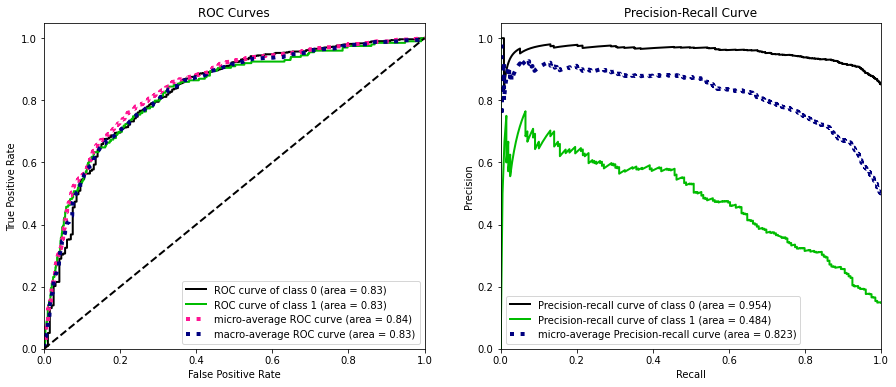

In [17]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/III.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV MFCC

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/IV.csv -------------
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Length of train:  15100 Length of test : 3775
Numbers of class instances (Train): {0: 13789, 1: 1311}
Numbers of class instances (Test): {0: 3450, 1: 325}
Length of train:  2622 Length of label : 2622
Numbers of class instances (Undersampling): {0: 1311, 1: 1311}
---------------Train Random forest----------------
Confusion matrix 
 [[2895  555]
 [ 137  188]]
Balance Accuracy= 0.7087959866220737
Class wise accuracy [0.83913043 0.57846154]
Per class accuracy class 1 0.8166887417218543
Per class accuracy class 0 0.8166887417218543
average per class  accuracy 0.8166887417218543
ClassificationReport 
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      3450
           1       0.25      0.58      0.35       325



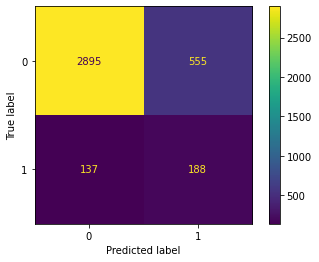

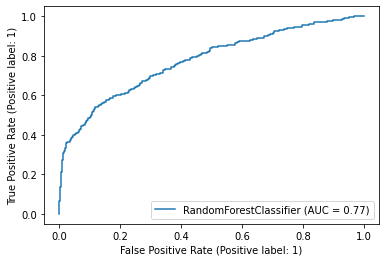

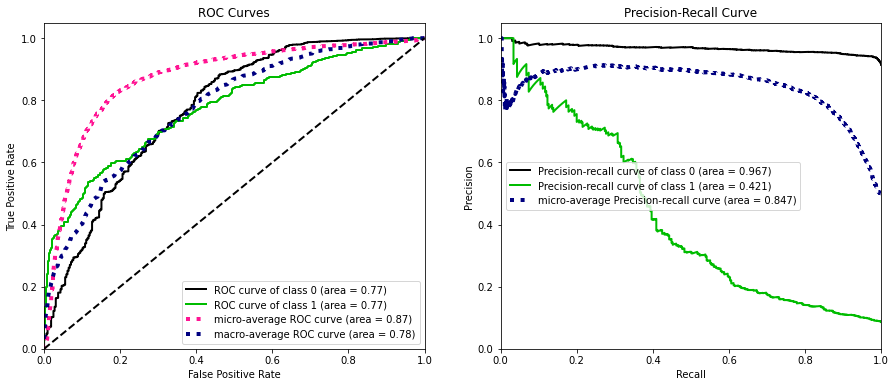

-------------------Train SVM----------------------
Confusion matrix 
 [[2572  878]
 [ 106  219]]
Balance Accuracy= 0.7096767001114828
Class wise accuracy [0.74550725 0.67384615]
Per class accuracy class 1 0.7393377483443708
Per class accuracy class 0 0.7393377483443708
average per class  accuracy 0.7393377483443708
ClassificationReport 
               precision    recall  f1-score   support

           0       0.96      0.75      0.84      3450
           1       0.20      0.67      0.31       325

    accuracy                           0.74      3775
   macro avg       0.58      0.71      0.57      3775
weighted avg       0.89      0.74      0.79      3775

Scores [0.69904762 0.71428571 0.74045802 0.71183206 0.70419847] 0.7139643765903309
F1 weighted 0.7936751687402568
Precison weighted 0.894920361006126
recall weighted 0.7393377483443708
Confusion matrix 



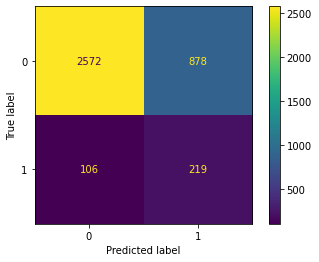

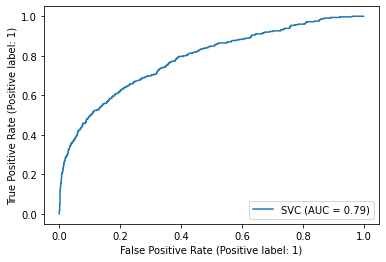

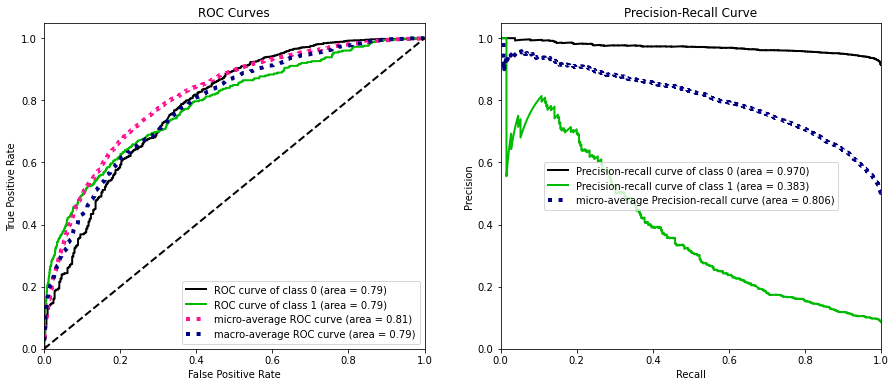

In [23]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/IV.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# II PSD

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/II.csv -------------
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Length of train:  15016 Length of test : 3755
Numbers of class instances (Train): {0: 845, 1: 14171}
Numbers of class instances (Test): {0: 227, 1: 3528}
Length of train:  1690 Length of label : 1690
Numbers of class instances (Undersampling): {0: 845, 1: 845}
---------------Train Random forest----------------
Confusion matrix 
 [[ 155   72]
 [1215 2313]]
Balance Accuracy= 0.6692158140789355
Class wise accuracy [0.68281938 0.65561224]
Per class accuracy class 1 0.6572569906790945
Per class accuracy class 0 0.6572569906790945
average per class  accuracy 0.6572569906790945
ClassificationReport 
               precision    recall  f1-score   support

           0       0.11      0.68      0.19       227
           1       0.97      0.66      0.78      3528

    

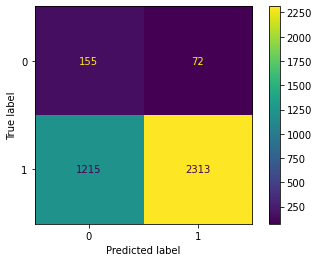

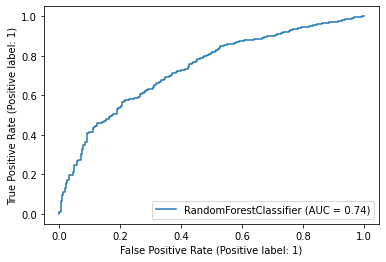

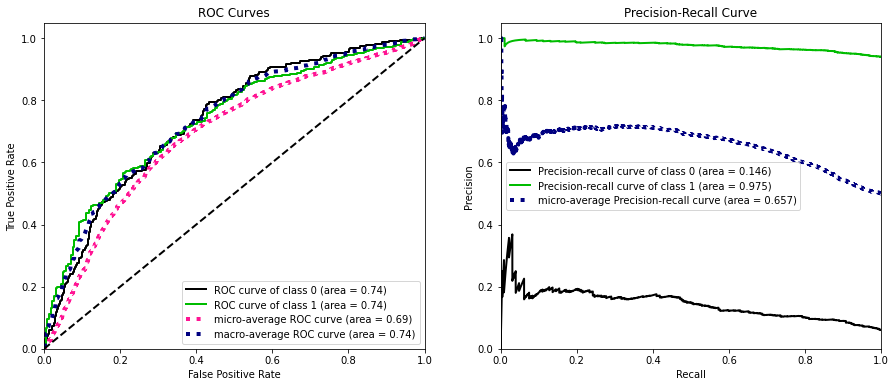

-------------------Train SVM----------------------
Confusion matrix 
 [[ 198   29]
 [2446 1082]]
Balance Accuracy= 0.5894680192194353
Class wise accuracy [0.8722467  0.30668934]
Per class accuracy class 1 0.340878828229028
Per class accuracy class 0 0.340878828229028
average per class  accuracy 0.340878828229028
ClassificationReport 
               precision    recall  f1-score   support

           0       0.07      0.87      0.14       227
           1       0.97      0.31      0.47      3528

    accuracy                           0.34      3755
   macro avg       0.52      0.59      0.30      3755
weighted avg       0.92      0.34      0.45      3755

Scores [0.53254438 0.55029586 0.5591716  0.57692308 0.5739645 ] 0.5585798816568046
F1 weighted 0.4466181723731824
Precison weighted 0.9195497295790807
recall weighted 0.340878828229028
Confusion matrix 



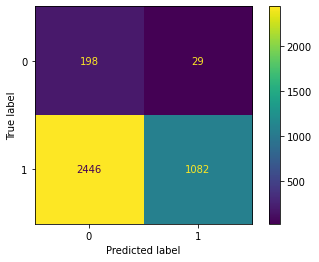

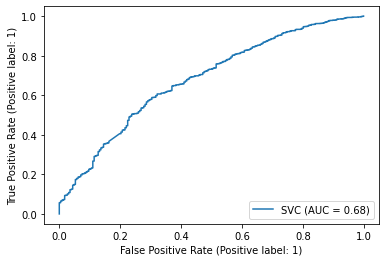

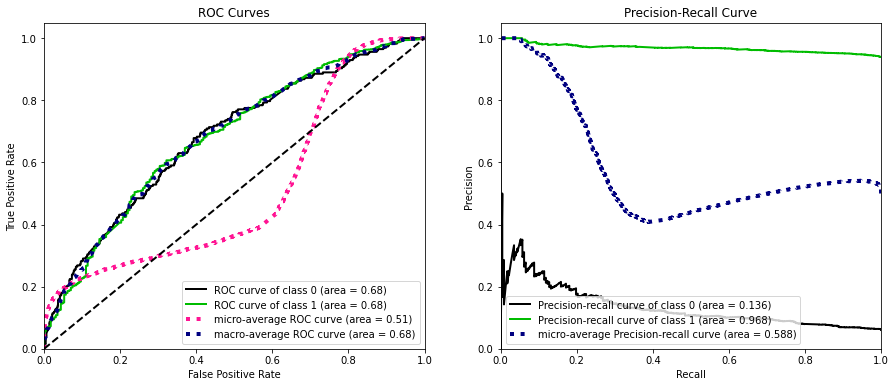

In [19]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/II.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# III PSD

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/III.csv -------------
Numbers of class instances (Raw): {0: 5725, 1: 956}
Numbers of class instances (Raw): {0: 5725, 1: 956}
Length of train:  5344 Length of test : 1337
Numbers of class instances (Train): {0: 4587, 1: 757}
Numbers of class instances (Test): {0: 1138, 1: 199}
Length of train:  1514 Length of label : 1514
Numbers of class instances (Undersampling): {0: 757, 1: 757}
---------------Train Random forest----------------
Confusion matrix 
 [[636 502]
 [ 76 123]]
Balance Accuracy= 0.588482835972481
Class wise accuracy [0.55887522 0.61809045]
Per class accuracy class 1 0.5676888556469708
Per class accuracy class 0 0.5676888556469708
average per class  accuracy 0.5676888556469708
ClassificationReport 
               precision    recall  f1-score   support

           0       0.89      0.56      0.69      1138
           1       0.20      0.62      0.30       199

    accuracy  

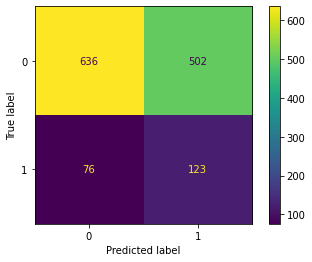

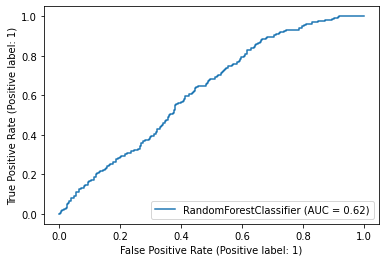

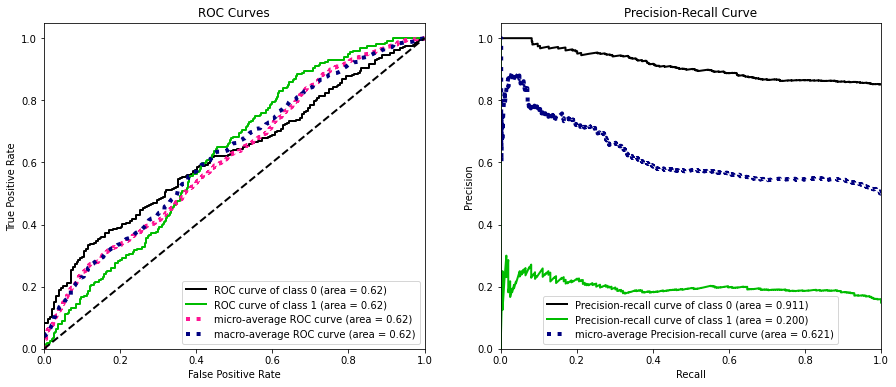

-------------------Train SVM----------------------
Confusion matrix 
 [[515 623]
 [ 57 142]]
Balance Accuracy= 0.5830580848000989
Class wise accuracy [0.45254833 0.71356784]
Per class accuracy class 1 0.4913986537023186
Per class accuracy class 0 0.4913986537023186
average per class  accuracy 0.4913986537023186
ClassificationReport 
               precision    recall  f1-score   support

           0       0.90      0.45      0.60      1138
           1       0.19      0.71      0.29       199

    accuracy                           0.49      1337
   macro avg       0.54      0.58      0.45      1337
weighted avg       0.79      0.49      0.56      1337

Scores [0.63036304 0.61386139 0.59405941 0.55445545 0.60596026] 0.599739907765611
F1 weighted 0.5565359344208609
Precison weighted 0.7939689335747234
recall weighted 0.4913986537023186
Confusion matrix 



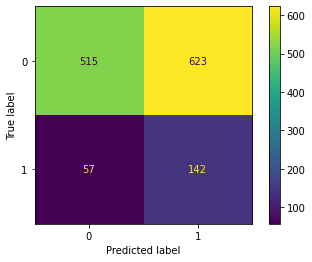

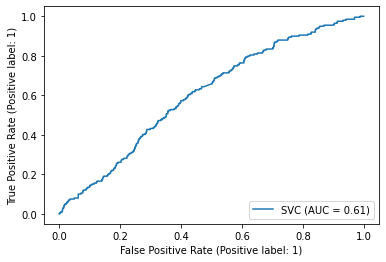

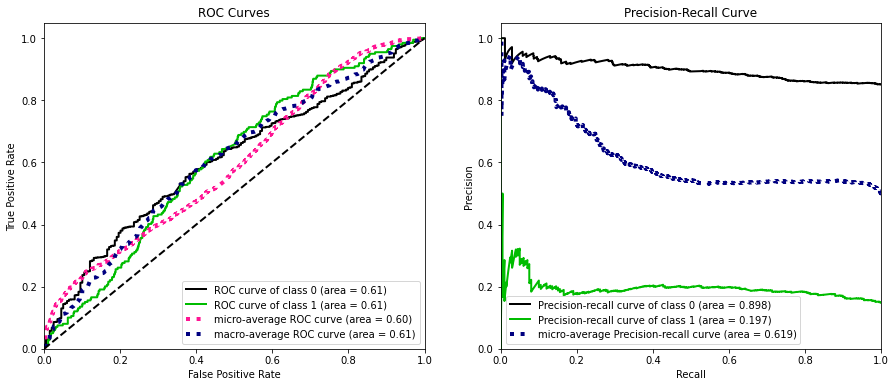

In [20]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/III.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV PSD

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/IV.csv -------------
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Length of train:  15100 Length of test : 3775
Numbers of class instances (Train): {0: 13789, 1: 1311}
Numbers of class instances (Test): {0: 3450, 1: 325}
Length of train:  2622 Length of label : 2622
Numbers of class instances (Undersampling): {0: 1311, 1: 1311}
---------------Train Random forest----------------
Confusion matrix 
 [[2306 1144]
 [ 139  186]]
Balance Accuracy= 0.6203567447045708
Class wise accuracy [0.6684058  0.57230769]
Per class accuracy class 1 0.6601324503311258
Per class accuracy class 0 0.6601324503311258
average per class  accuracy 0.6601324503311258
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.67      0.78      3450
           1       0.14      0.57      0.22       325

 

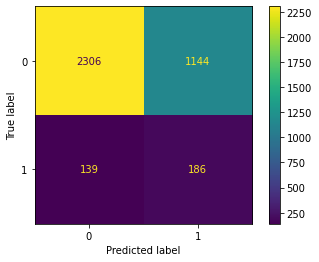

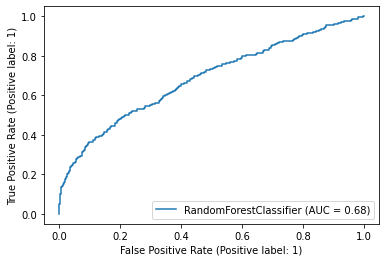

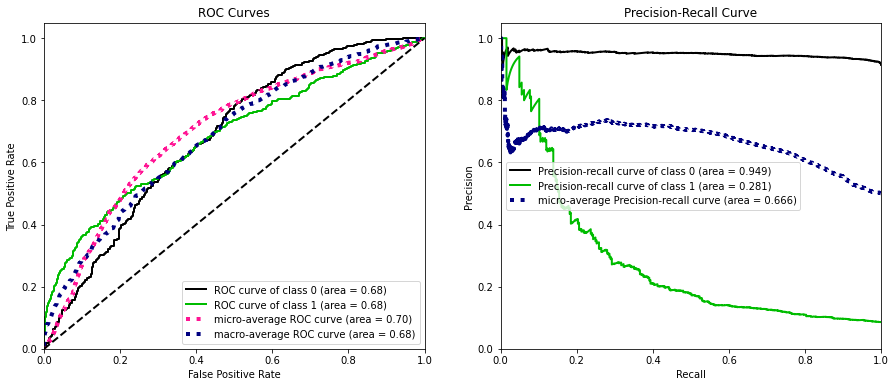

-------------------Train SVM----------------------
Confusion matrix 
 [[2173 1277]
 [ 148  177]]
Balance Accuracy= 0.5872352285395763
Class wise accuracy [0.62985507 0.54461538]
Per class accuracy class 1 0.6225165562913907
Per class accuracy class 0 0.6225165562913907
average per class  accuracy 0.6225165562913907
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.63      0.75      3450
           1       0.12      0.54      0.20       325

    accuracy                           0.62      3775
   macro avg       0.53      0.59      0.48      3775
weighted avg       0.87      0.62      0.71      3775

Scores [0.60190476 0.54857143 0.59923664 0.57824427 0.59732824] 0.5850570701563068
F1 weighted 0.7053728236979172
Precison weighted 0.8661117591266462
recall weighted 0.6225165562913907
Confusion matrix 



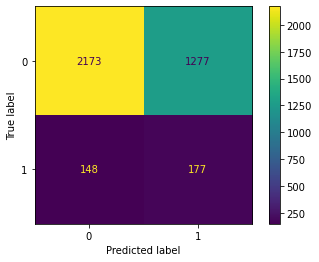

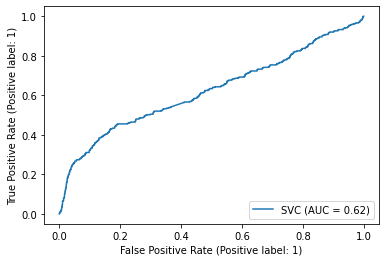

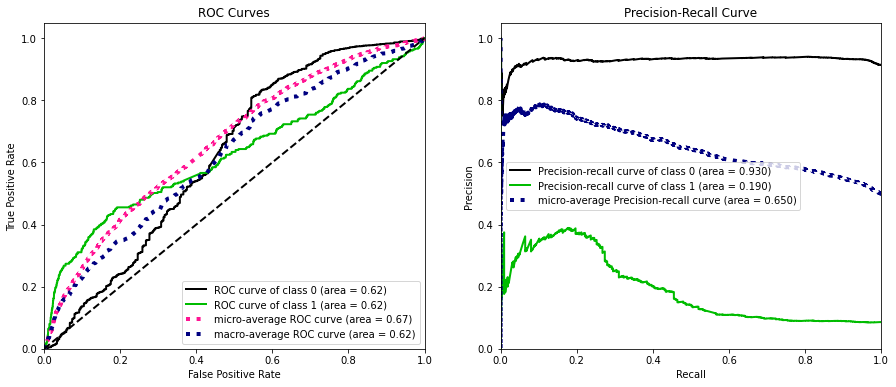

In [21]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/IV.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV (Time and PSD)

(18875, 20) (18875, 6)
(18875, 25)
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Numbers of class instances (Raw): {0: 17239, 1: 1636}
Length of train:  15100 Length of test : 3775
Numbers of class instances (Train): {0: 13789, 1: 1311}
Numbers of class instances (Test): {0: 3450, 1: 325}
Length of train:  2622 Length of label : 2622
Numbers of class instances (Undersampling): {0: 1311, 1: 1311}
---------------Train Random forest----------------
Confusion matrix 
 [[2877  573]
 [ 106  219]]
Balance Accuracy= 0.7538795986622073
Class wise accuracy [0.83391304 0.67384615]
Per class accuracy class 1 0.8201324503311258
Per class accuracy class 0 0.8201324503311258
average per class  accuracy 0.8201324503311258
ClassificationReport 
               precision    recall  f1-score   support

           0       0.96      0.83      0.89      3450
           1       0.28      0.67      0.39       325

    accuracy                           0.82      3775
   macro avg       0.62      0.75  

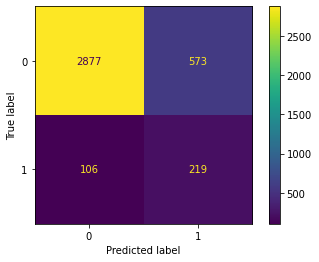

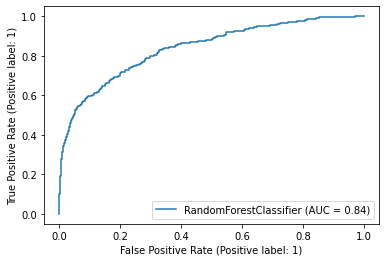

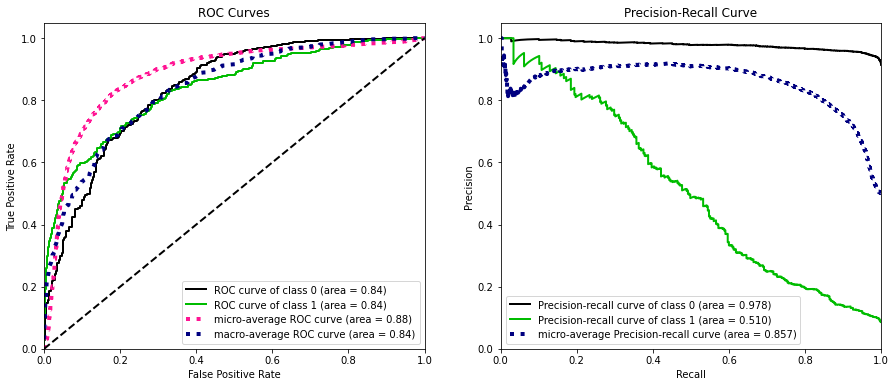

-------------------Train SVM----------------------
Confusion matrix 
 [[3179  271]
 [ 184  141]]
Balance Accuracy= 0.6776477146042363
Class wise accuracy [0.92144928 0.43384615]
Per class accuracy class 1 0.8794701986754967
Per class accuracy class 0 0.8794701986754967
average per class  accuracy 0.8794701986754967
ClassificationReport 
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      3450
           1       0.34      0.43      0.38       325

    accuracy                           0.88      3775
   macro avg       0.64      0.68      0.66      3775
weighted avg       0.89      0.88      0.89      3775

Scores [0.66285714 0.67428571 0.70610687 0.6851145  0.70419847] 0.6865125408942203
F1 weighted 0.8858146721507358
Precison weighted 0.8933683953570631
recall weighted 0.8794701986754967
Confusion matrix 



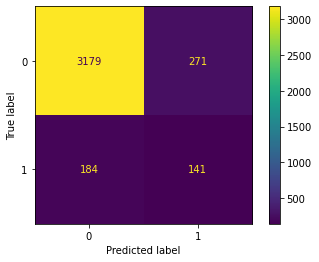

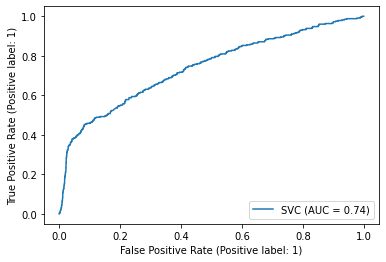

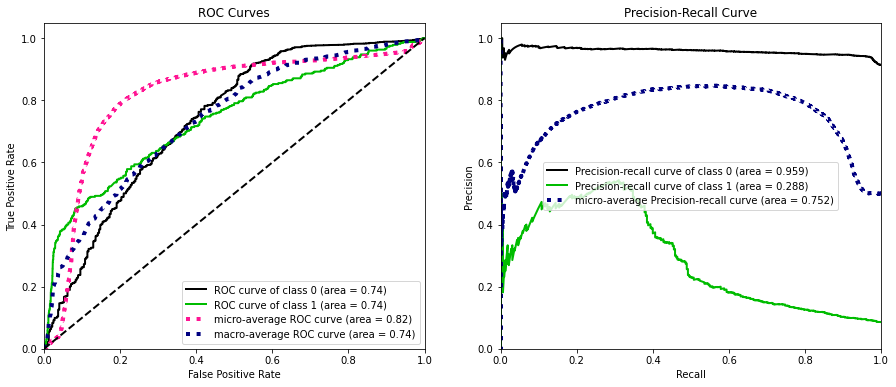

In [12]:
filepath1='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv'
filepath2='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/IV.csv'

df1=pd.read_csv(filepath1)
df2=pd.read_csv(filepath2)

df1.rename(columns={ df1.columns[-1]: "label" }, inplace = True)  
df2.rename(columns={ df2.columns[-1]: "label" }, inplace = True)  
print(df1.shape,df2.shape)

df3=pd.concat([df1.iloc[:,:-1],df2.iloc[:,:-1],df1.iloc[:,-1:]],axis=1,ignore_index=False)
print(df3.shape)

## Normalize data
norm_data= normalize_data(df3)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# II TIME +PSD

(18771, 20) (18771, 6)
(18771, 25)
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Length of train:  15016 Length of test : 3755
Numbers of class instances (Train): {0: 845, 1: 14171}
Numbers of class instances (Test): {0: 227, 1: 3528}
Length of train:  1690 Length of label : 1690
Numbers of class instances (Undersampling): {0: 845, 1: 845}
---------------Train Random forest----------------
Confusion matrix 
 [[ 177   50]
 [ 810 2718]]
Balance Accuracy= 0.7750719230423446
Class wise accuracy [0.77973568 0.77040816]
Per class accuracy class 1 0.7709720372836218
Per class accuracy class 0 0.7709720372836218
average per class  accuracy 0.7709720372836218
ClassificationReport 
               precision    recall  f1-score   support

           0       0.18      0.78      0.29       227
           1       0.98      0.77      0.86      3528

    accuracy                           0.77      3755
   macro avg       0.58      0.78     

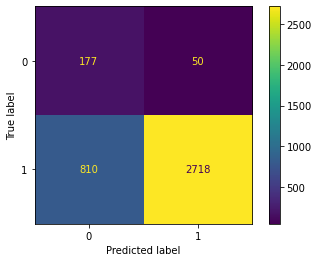

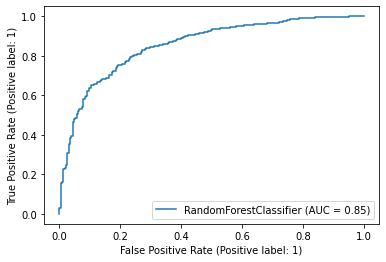

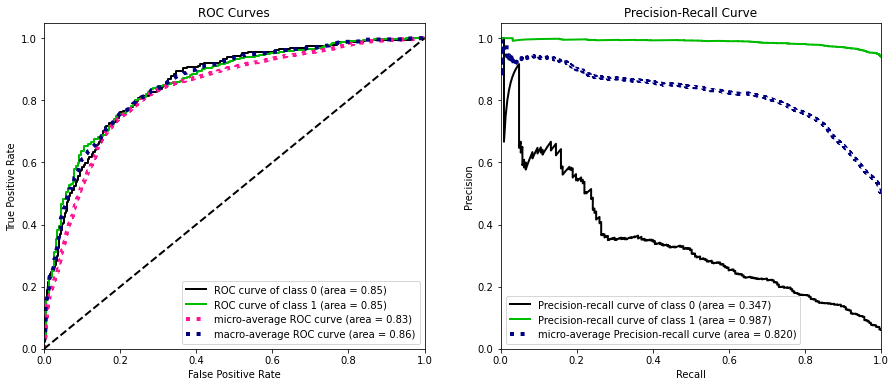

-------------------Train SVM----------------------
Confusion matrix 
 [[ 178   49]
 [1343 2185]]
Balance Accuracy= 0.7017360174613163
Class wise accuracy [0.78414097 0.61933107]
Per class accuracy class 1 0.6292942743009321
Per class accuracy class 0 0.6292942743009321
average per class  accuracy 0.6292942743009321
ClassificationReport 
               precision    recall  f1-score   support

           0       0.12      0.78      0.20       227
           1       0.98      0.62      0.76      3528

    accuracy                           0.63      3755
   macro avg       0.55      0.70      0.48      3755
weighted avg       0.93      0.63      0.72      3755

Scores [0.65088757 0.70414201 0.66863905 0.69526627 0.70710059] 0.685207100591716
F1 weighted 0.7248807084398308
Precison weighted 0.9260141527404578
recall weighted 0.6292942743009321
Confusion matrix 



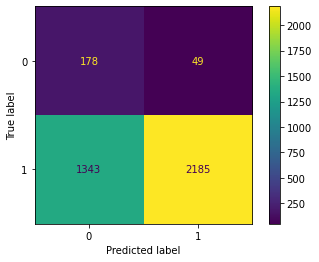

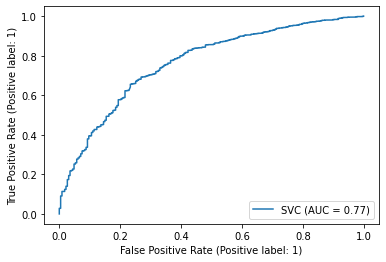

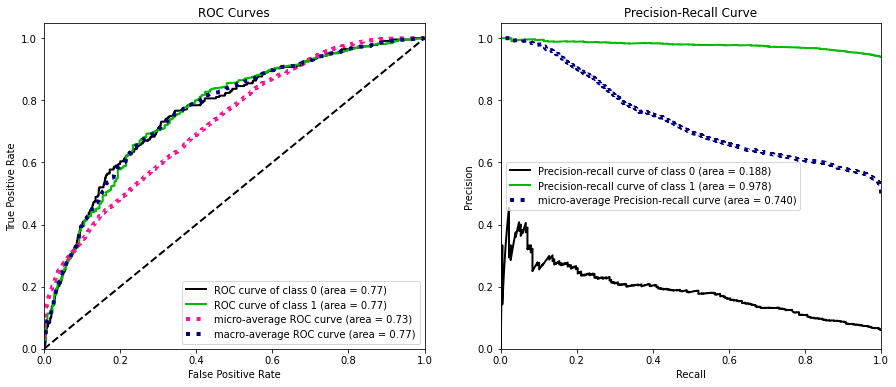

In [13]:
filepath1='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv'
filepath2='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/II.csv'

df1=pd.read_csv(filepath1)
df2=pd.read_csv(filepath2)

df1.rename(columns={ df1.columns[-1]: "label" }, inplace = True)  
df2.rename(columns={ df2.columns[-1]: "label" }, inplace = True)  
print(df1.shape,df2.shape)

df3=pd.concat([df1.iloc[:,:-1],df2.iloc[:,:-1],df1.iloc[:,-1:]],axis=1,ignore_index=False)
print(df3.shape)

## Normalize data
norm_data= normalize_data(df3)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# III TIME +PSD

(6681, 20) (6681, 6)
(6681, 25)
Numbers of class instances (Raw): {0: 5725, 1: 956}
Numbers of class instances (Raw): {0: 5725, 1: 956}
Length of train:  5344 Length of test : 1337
Numbers of class instances (Train): {0: 4587, 1: 757}
Numbers of class instances (Test): {0: 1138, 1: 199}
Length of train:  1514 Length of label : 1514
Numbers of class instances (Undersampling): {0: 757, 1: 757}
---------------Train Random forest----------------
Confusion matrix 
 [[894 244]
 [ 64 135]]
Balance Accuracy= 0.7319903559979157
Class wise accuracy [0.78558875 0.67839196]
Per class accuracy class 1 0.7696335078534031
Per class accuracy class 0 0.7696335078534031
average per class  accuracy 0.7696335078534031
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.79      0.85      1138
           1       0.36      0.68      0.47       199

    accuracy                           0.77      1337
   macro avg       0.64      0.73      0.66      13

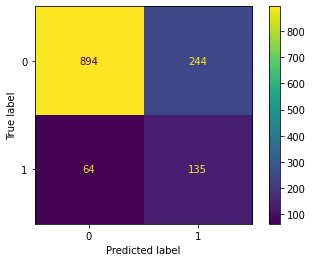

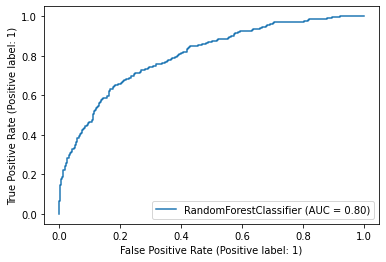

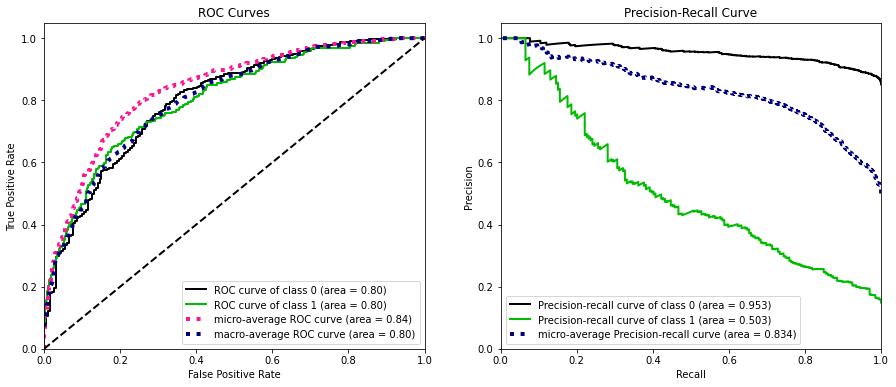

-------------------Train SVM----------------------
Confusion matrix 
 [[704 434]
 [ 82 117]]
Balance Accuracy= 0.6032844362409587
Class wise accuracy [0.61862917 0.5879397 ]
Per class accuracy class 1 0.6140613313388182
Per class accuracy class 0 0.6140613313388182
average per class  accuracy 0.6140613313388182
ClassificationReport 
               precision    recall  f1-score   support

           0       0.90      0.62      0.73      1138
           1       0.21      0.59      0.31       199

    accuracy                           0.61      1337
   macro avg       0.55      0.60      0.52      1337
weighted avg       0.79      0.61      0.67      1337

Scores [0.60066007 0.6039604  0.6039604  0.60066007 0.63576159] 0.6090005026992766
F1 weighted 0.6693241112926975
Precison weighted 0.7939665310816556
recall weighted 0.6140613313388182
Confusion matrix 



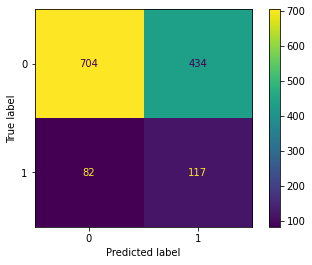

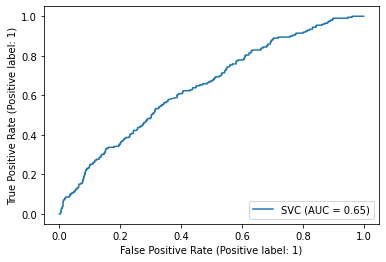

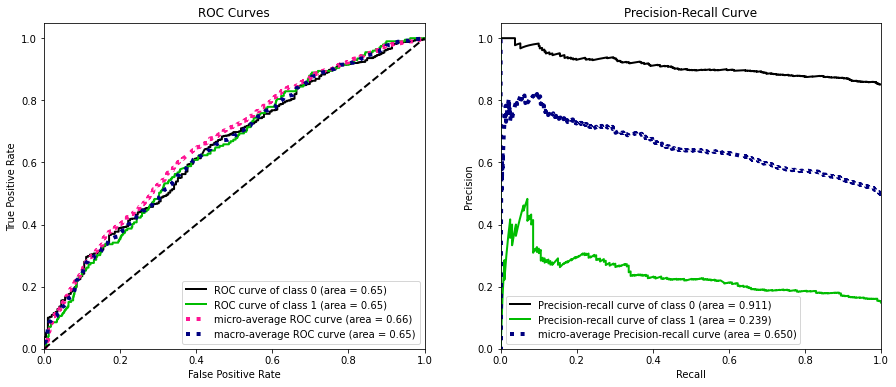

In [14]:
filepath1='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/III.csv'
filepath2='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/III.csv'

df1=pd.read_csv(filepath1)
df2=pd.read_csv(filepath2)

df1.rename(columns={ df1.columns[-1]: "label" }, inplace = True)  
df2.rename(columns={ df2.columns[-1]: "label" }, inplace = True)  
print(df1.shape,df2.shape)

df3=pd.concat([df1.iloc[:,:-1],df2.iloc[:,:-1],df1.iloc[:,-1:]],axis=1,ignore_index=False)
print(df3.shape)

## Normalize data
norm_data= normalize_data(df3)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

In [15]:
import sklearn
print(sklearn.__version__)
sklearn.metrics.get_scorer_names()

1.1.2


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_